Processing items: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.52item/s]


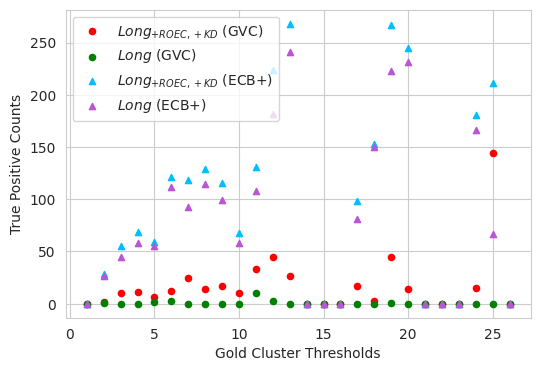

In [5]:
import pickle
import collections
import nltk.data
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns

def get_cluster_size_error(dataset,evt_mention_map_test, clus_map):
  
    fp_topics = []
    values = []
    c_to_p = []
    cluster = []
    cluster_to_pair = defaultdict(int)
    gold_clus = []
    dataset_folder = f'./datasets/{dataset}'
    full_path = f"{dataset_folder}/lh_prev_scores_full.csv"
    prev_data = pd.read_csv (full_path)
    
    df_pos = prev_data.loc[(prev_data['coref_label']==1)] 
    pair_list = df_pos['pairs'].tolist()

    for index, x in enumerate(pair_list):
        pair = eval(df_pos['pairs'].tolist()[index])
        men_1 = pair[0]
        men_2 = pair[1]
        c_to_p.append((pair, evt_mention_map_test[men_1]['gold_cluster'] ))


    result_dict = dict(zip(*zip(*c_to_p)))

    
    result_dict_large = [x for x, y in result_dict.items() if y in clus_map]
    len(result_dict_large)

    for index, x in enumerate(pair_list):
        pair = eval(df_pos['pairs'].tolist()[index])
        men_1 = pair[0]
        men_2 = pair[1]
        c_to_p.append((pair, evt_mention_map_test[men_1]['gold_cluster'] ))
      
        if pair in result_dict_large:
            values.append((pair,prev_data['scores_lh_prev'][index], prev_data['scores_r1_k1'][index]  ))
    df_large_cluster_anal = pd.DataFrame(values, columns=['mention_pair', 'scores_lh_prev', 'scores_r1_k1'])
    df_hard_pos_large_clus = df_large_cluster_anal.loc[(df_large_cluster_anal['scores_lh_prev']==0) &\
                                                       (df_large_cluster_anal['scores_r1_k1']==1)]
    df_hard_neg_large_clus = df_large_cluster_anal.loc[(df_large_cluster_anal['scores_lh_prev']==1) &\
                                                       (df_large_cluster_anal['scores_r1_k1']==0)]
    
    df_kd_only = df_large_cluster_anal.loc[(df_large_cluster_anal['scores_r1_k1']==1)]
    df_dpos_only = df_large_cluster_anal.loc[(df_large_cluster_anal['scores_lh_prev']==1)]
    kd_correct = len(df_hard_pos_large_clus)
    dpos_correct =  len(df_hard_neg_large_clus)
    kd_only = len(df_kd_only)
    dpos_only = len(df_dpos_only)
    return kd_correct, dpos_correct, kd_only,dpos_only
    
def get_cluster_maps(dataset, thres): 
    
    dataset_folder = f'./datasets/{dataset}/'
    mention_map = pickle.load(open(dataset_folder + "/mention_map.pkl", 'rb'))
    evt_mention_map = {m_id: m for m_id, m in mention_map.items() if m['men_type'] == 'evt'}
    evt_mention_map_test = {m_id: m for m_id, m in mention_map.items() if m['men_type'] == 'evt' and m['split']=='test'}
    inner_monologue_map = pickle.load(open(dataset_folder + f'/im_map_{dataset}.pkl', 'rb'))
   
    #get the clusters

    cluster_set = []
    for x, y in evt_mention_map_test.items():
        cluster_set.append(y['gold_cluster'])

    len(set(cluster_set))

    counter = collections.Counter(cluster_set)
    #cluster_dict = counter.items()

    cluster_dict = dict(counter)
    clus_large = {x:y for x, y in cluster_dict.items() if y == thres}  
    return clus_large, evt_mention_map_test


def save_cluster_plots(df_ecb, df_gvc):
    plt.style.use('default')
    sns.set_style("whitegrid")

    thresholds = df_ecb['c_thres']
    values_set1 = df_gvc['kd_correct']
    values_set2 = df_gvc['dpos_correct']
    values_set3 = df_ecb['kd_only'][0:26] # showing only overlapping cluster sizes
    values_set4 = df_ecb['dpos_only'][0:26]
    all_values = np.concatenate([values_set1, values_set2, values_set3, values_set4])

    colors = plt.cm.viridis(all_values)
    
    # Create a scatter plot
    plt.figure(figsize=(6, 4))

    plt.scatter(thresholds, values_set1, label= '$Long_{+ROEC,+KD}$ (GVC)', color='red', marker='o', s=20)
    plt.scatter(thresholds, values_set2, label='$Long$ (GVC)', color='green', marker='o', s=20)
    plt.scatter(thresholds, values_set3, label='$Long_{+ROEC,+KD}$ (ECB+)', color = 'deepskyblue', marker='^', s=20)
    plt.scatter(thresholds, values_set4, label='$Long$ (ECB+)', color = 'mediumorchid', marker='^', s=20)

    # Set labels and title
    plt.xlabel('Gold Cluster Thresholds')
    plt.ylabel('True Positive Counts')


    # Display legend
    plt.legend()
    #plt.savefig('cluster_plot_final.png', bbox_inches='tight')
    # Show the plot
    plt.show()


def main(dataset, cluster_range):
    dataset = 'gvc'
    kd_error = []
    dpos_error = []
    kd = []
    dpos = []
    k_only = []
    d_only = []
    
    cluster_thresholds = [i+1 for i in range(cluster_range)]
    for c_thres in tqdm(cluster_thresholds,desc="Processing items", unit="item") :
        clus_large, evt_mention_map_test = get_cluster_maps(dataset, c_thres)   
        kd_correct, dpos_correct, kd_only,dpos_only = get_cluster_size_error(dataset,evt_mention_map_test, clus_large)
        kd_error.append((c_thres, kd_correct, dpos_correct, kd_only,dpos_only))
        kd.append((kd_correct, "L-KD"))
        dpos.append((dpos_correct, "dpos"))
        k_only.append((kd_only, "kd-only"))
        d_only.append((dpos_only, "dpos-only"))
    df_clustering = pd.DataFrame(kd_error, columns=['c_thres', 'kd_correct', 'dpos_correct','kd_only', 'dpos_only'])
    return df_clustering

if __name__ == '__main__':
    cluster_range = 26 # set the cluster range, ECB+ (~36) has a higher range of clustres compared to GVC (~26)
    df_clustering_gvc = main('gvc', cluster_range)
    df_clustering_ecb = main('ecb', cluster_range)
    save_cluster_plots(df_clustering_ecb, df_clustering_gvc)
 
   